# K-Nearest Neighbors Homework Solutions
***
**Name**: Saikrishna Jaliparthy  
***

This assignment is due on Moodle by **5pm on Friday January 26th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement a K-Nearest Neighbor framework to take an image of a handwritten digit and predict which digit it corresponds to.  

<br>

![Samples of Handwritten Digits](wide_mnist.png "MNIST Digits")


<br>

This homework is designed to be pretty easy. If you're spending a ton of time on this assignment, then you are either:

- not prepared to take this course (i.e., if you're struggling with Python)
- seriously over-thinking the assignment
- trying to implement too much of KNN from scratch


Most of this assignment will be done by calling libraries that are already implemented for you. If you are implementing $n$-dimensional search or your own distance metrics, you are generating extra work for yourself and making yourself vulnerable to errors. 

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [10]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
%matplotlib inline

### [5 points] Problem 1
***

The class below will load and store the MNIST data.  Load the data and then report: 
- The number of examples in the training set 
- The number of examples in the test set 
- The number of pixels in each image. 

In [2]:
class Numbers:
    """
    Class to store MNIST data
    """
    def __init__(self, location):

        import pickle, gzip

        # load data from file 
        f = gzip.open(location, 'rb')
        train_set, valid_set, test_set = pickle.load(f)
        f.close()

        # store for use later  
        self.train_x, self.train_y = train_set
        self.test_x, self.test_y = valid_set

In [3]:
data = Numbers("../data/mnist.pklz")
print("The number of examples in the training set:",len(data.train_x))
print("The number of examples in the test set:",len(data.test_x))
print("The number of pixels in each image",len(data.train_x[0]))

The number of examples in the training set: 50000
The number of examples in the test set: 10000
The number of pixels in each image 784


### [30 points] Problem 2
***

The class below will perform K-Nearest Neighbor classification on our handwritten digit data. Your tasks are as follows:   

1. Modify the `label_counts` function to return a dictionary of frequencies corresponding to each label in the training set. 
1. Modify the `majority` function so that it returns the _label_ that appears most frequently in the $K$-nearest neighbors of the query point.  In the case that the maximum frequency occurs for two or more labels, return the one that appears most frequently in the entire training set. In the case that there is still a tie, break the tie in any way that you choose. 
1. Modify the `classify` function so that it finds the _indices_ of the $K$ closest training examples to the query point and then calls the `majority` function to return the predicted label. Almost all of the heavy lifting here will be done by the BallTree object from `sklearn.neighbors`, so you'll want to start out by reading the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html).  
1. Modify the `confusion_matrix` function to classify examples and record the results in a confusion matrix. You should construct the confusion matrix on your own.  Don't call any additional functions from sklearn to do it for you.

The class Knearest also implements an `accuracy` function which you will use in **Problem 3**.  You should not have to modify this function. 

We've given you unit tests down below based on the simple example worked out in lecture.  At first your code will fail all of them.  Do not move on to **Problem 3** until your code passes all of the unit tests. In addition, passing the unit tests does not guarantee that your implementation is robust and that you'll earn full points on this problem.  You should be designing your own additional tests as well. 

In [8]:
class Knearest:
    """
    kNN classifier
    """

    def __init__(self, X, y, k=5):
        """
        Creates a kNN instance

        :param x: Training data input
        :param y: Training data output
        :param k: The number of nearest points to consider in classification
        """
        
        from sklearn.neighbors import BallTree

        self._kdtree = BallTree(X)
        self._y = y
        self._k = k
        self._counts = self.label_counts()
        
    def label_counts(self):
        """
        Given the training labels, return a dictionary d where d[y] is  
        the number of times that label y appears in the training set. 
        """
        d={}
        for i in self._y:
            if i not in d:
                d[i]=1
            else:
                d[i]= d[i]+1
        return d

    def majority(self, neighbor_indices):
        """
        Given the indices of training examples, return the majority label. Break ties 
        by choosing the tied label that appears most often in the training data. 

        :param neighbor_indices: The indices of the k nearest neighbors
        """
        from collections import Counter
        assert len(neighbor_indices) == self._k, "Did not get k neighbor indices"
        high=[self._y[i] for i in neighbor_indices]
        h1=Counter(high).most_common()[0]
        for i in range(1,len(Counter(high).most_common())):
            h2=Counter(high).most_common()[i]
            if h2[1]==h1[1]:
                if self._counts[h2[0]]> self._counts[h1[0]]:
                    h1=h2
                else:
                    return h1[0]
        return h1[0]
    

    def classify(self, example):
        """
        Given an example, return the predicted label. 

        :param example: A representation of an example in the same
        format as a row of the training data
        """
        dist, ind=self._kdtree.query(example.reshape(-1,len(example)),self._k)
        return self.majority(np.array(ind).reshape(-1)) 


    def confusion_matrix(self, test_x, test_y):
        """
        Given a matrix of test examples and labels, compute the confusion
        matrix for the current classifier.  Should return a 2-dimensional
        numpy array of ints, C, where C[ii,jj] is the number of times an 
        example with true label ii was labeled as jj.

        :param test_x: test data 
        :param test_y: true test labels 
        """
        
        C = np.zeros((10,10), dtype=int)
        for xx, yy in zip(test_x, test_y):
            C[xx][yy] += 1
        return C 
            
    @staticmethod
    def accuracy(C):
        """
        Given a confusion matrix C, compute the accuracy of the underlying classifier.
        
        :param C: a confusion matrix 
        """
        return np.sum(C.diagonal()) / C.sum()
        

Here are the unit tests.  You don't need to modify them.  Simply execute the cell and observe the output. 

In [5]:
import unittest

class TestKnn(unittest.TestCase):
    def setUp(self):
        self.x = np.array([[2, 0], [4, 1], [6, 0], [1, 4], [2, 4], [2, 5], [4, 4], [0, 2], [3, 2], [4, 2], [5, 2], [5, 5]])
        self.y = np.array([+1, +1, +1, +1, +1, +1, +1, -1, -1, -1, -1, -1])
        self.knn = {}
        for ii in [1, 2, 3]:
            self.knn[ii] = Knearest(self.x, self.y, ii)

        self.queries = np.array([[1, 5], [0, 3], [6, 4]])
        
    def test0(self):
        """
        Test the label counter 
        """
        self.assertEqual(self.knn[1]._counts[-1], 5)
        self.assertEqual(self.knn[1]._counts[1], 7)

    def test1(self):
        """
        Test 1NN
        """
        self.assertEqual(self.knn[1].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[1].classify(self.queries[1]), -1)
        self.assertEqual(self.knn[1].classify(self.queries[2]), -1)

    def test2(self):
        """
        Test 2NN
        """
        self.assertEqual(self.knn[2].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[2]),  1)

    def test3(self):
        """
        Test 3NN
        """
        self.assertEqual(self.knn[3].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[2]), -1)
        
tests = TestKnn()
tests_to_run = unittest.TestLoader().loadTestsFromModule(tests)
unittest.TextTestRunner().run(tests_to_run)

....
----------------------------------------------------------------------
Ran 4 tests in 0.315s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

### [15 points] Problem 3
***

In this problem you'll explore the performance of the classifier you've written.  A word of advice: don't use the entire training set, especially at first.  We'll be using this dataset again later on with techniques that scale better.    

**Part A**: Explore the relationship between the number of training examples and accuracy on the test set. Comment on your findings and support your observations with some kind of graphic. 

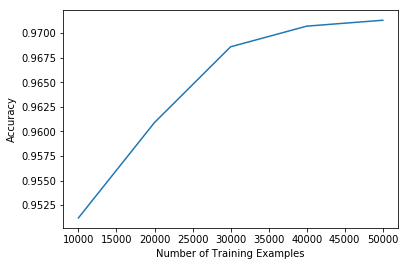

In [17]:
# c=[]
b=[]
x=[]
for i in range(1,6):
   
    k1=Knearest(data.train_x[0:i*10000],data.train_y[0:i*10000])
    x.append(i*10000)
    y=[]
    for j in data.test_x:
        c=k1.classify(j)
        y.append(c)
        
    a=k1.accuracy(k1.confusion_matrix(y,data.test_y))
    b.append(a)

plt.plot(x,b)
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy")
plt.show()

 By analyzing the above generated graph we can observe that number of training examples has an effect on the accuracy.Small ammounts of Training examples will result in a low accuracy rate, but as we approach large amounts of training examples accuracy also increases.

**Part B**: Explore the relationship between the number of nearest neighbors and accuracy on the test set. Comment on your findings and support your observations with some kind of graphic. 

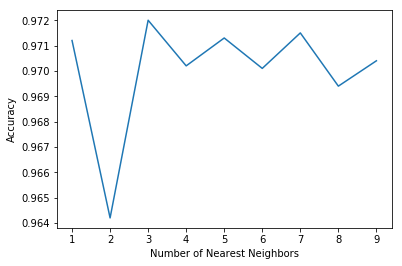

In [18]:
b1=[]
x1=[]
for i in range(1,10):
   
    k11=Knearest(data.train_x,data.train_y,i)
    x1.append(i)
    y1=[]
    for j in data.test_x:
        c1=k11.classify(j)
        y1.append(c1)
        
    a1=k11.accuracy(k11.confusion_matrix(y1,data.test_y))
    b1.append(a1)

plt.plot(x1,b1)
plt.xlabel("Number of Nearest Neighbors")
plt.ylabel("Accuracy")
plt.show()

By observing the above generated graph we can observe that number of nearest neighbors(k) has an effect on accuracy. At k=3 maximum accuracy of around 97.2 acheieved but as we increase the value of k the accuracy value changes randomly. When we carefully analyse the graph even order nearest neighbors has less accuracy when compared to adjacent odd order nearest neighbors.

**Part C**: Which numbers get confused with each other the most easily?  Use the confusion_matrix function that you wrote above to support your conclusion.  Then use the `view_digit` function given below to plot a few examples of misclassified digits and discuss possible reasons for the misclassifications.  (Investigating misclassified examples is called **error analysis** and is an important step in the development of any classification technique).  

In [41]:
def view_digit(example, label=None):
    if label: print("true label: {:d}".format(label))
    plt.imshow(example.reshape(28,28), cmap='gray');
    
#view_digit(data.train_x[0,:], data.train_y[0])

In [22]:
k3=Knearest(data.train_x,data.train_y)
y=[]
for j in data.test_x:
    c3=k3.classify(j)
    y.append(c3)
z=k3.confusion_matrix(y,data.test_y)
print(z)
    

[[ 983    0    3    0    0    2    1    0    3    3]
 [   0 1060    9    0   10    2    0   10    8    3]
 [   3    1  953    3    1    1    0    0    1    0]
 [   0    0    2 1007    0   17    0    0   15   10]
 [   0    1    1    0  941    2    0    3    4   11]
 [   0    0    1    6    0  863    1    0   13    2]
 [   2    1    1    1    0   17  965    0    4    0]
 [   1    1   17    4    6    3    0 1070    5    7]
 [   0    0    1    6    0    3    0    0  947    1]
 [   2    0    2    3   25    5    0    7    9  924]]


In [74]:
for q in range(10):
    for w in range(10):
        if q!=w and z[q][w]>=10 :
            print('<',q,w,'>')

< 1 4 >
< 1 7 >
< 3 5 >
< 3 8 >
< 3 9 >
< 4 9 >
< 5 8 >
< 6 5 >
< 7 2 >
< 9 4 >


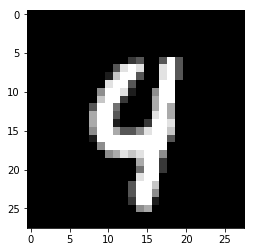

In [81]:
#k4=Knearest(data.train_x,data.train_y)
for i in range(0,data.test_x.shape[0]):
    if(data.test_y[i]==4 and k3.classify(data.test_x[i])==9):
        view_digit(data.test_x[i])
        break

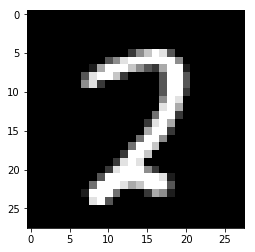

In [82]:
for i in range(0,data.test_x.shape[0]):
    if(data.test_y[i]==2 and k3.classify(data.test_x[i])==7):
        view_digit(data.test_x[i])
        break

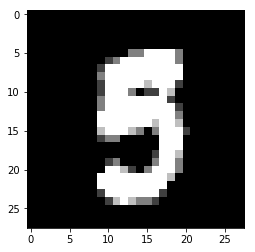

In [85]:
for i in range(0,data.test_x.shape[0]):
    if(data.test_y[i]==5 and k3.classify(data.test_x[i])==3):
        view_digit(data.test_x[i])
        break

By using the confusion matrix, we can observe the numbers confused from the above three generated values using the view digit function. The pairs are:

a) True label is:4 and Predicted label is:9
b) True label is:2 and Predicted label is:7
c) True label is:5 and Predicted label is:3